In [1]:
from astropy.io import fits
from astropy.visualization import astropy_mpl_style

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.patches import Ellipse 
from matplotlib import axes
from matplotlib.patches import Ellipse

from scipy.optimize import curve_fit
import scipy.integrate as spi
plt.style.use(astropy_mpl_style)
from astropy.utils.data import get_pkg_data_filename

import sep
from matplotlib.pyplot import imshow
from numpy import nanmean, nanstd, nanvar 

File:sc_UDS306827_P1M2Q4_P1M3Q4_033_1
Number of target galaxies:  1
Number of detections: 2


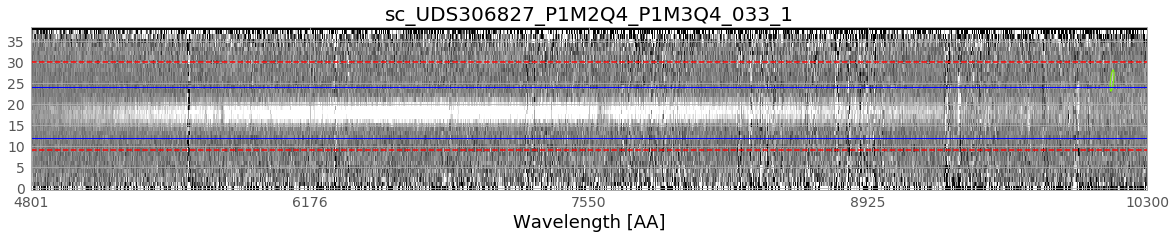

File:sc_UDS306930_P2M3Q4_P2M4Q4_020_1
Number of target galaxies:  1
Number of detections: 7


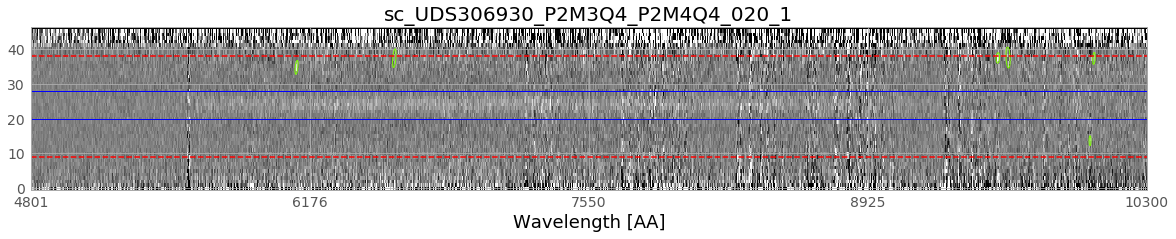

File:sc_UDS307055_P3M4Q3_023_1
Number of target galaxies:  1
Number of detections: 16


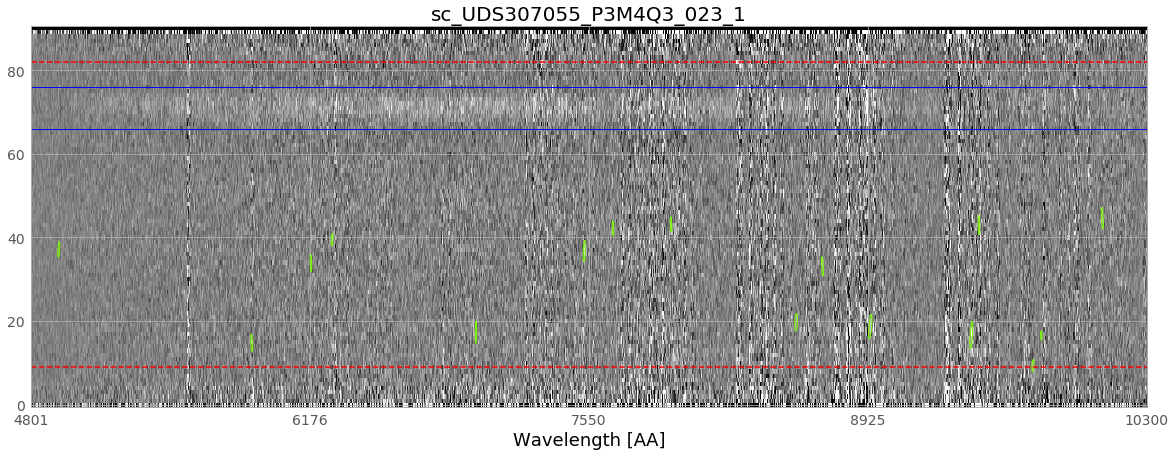

File:sc_UDS307318_P1M3Q4_P1M4Q4_026_1
Number of target galaxies:  1
Number of detections: 1


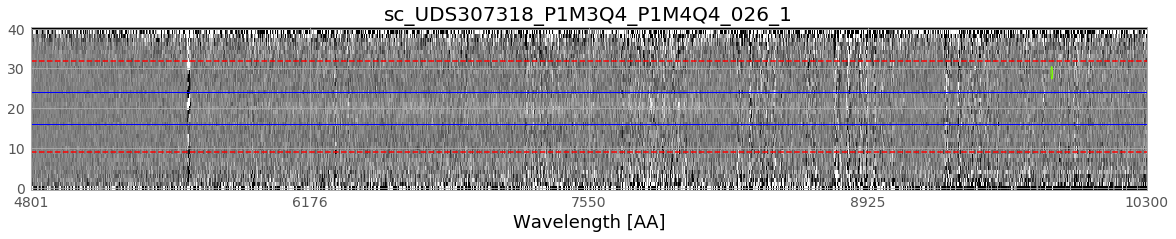

Missing keyword for file sc_UDS307621_P2M1Q3_020_2
File:sc_UDS307621_P2M1Q3_020_2
Number of target galaxies:  2
Number of detections: 4


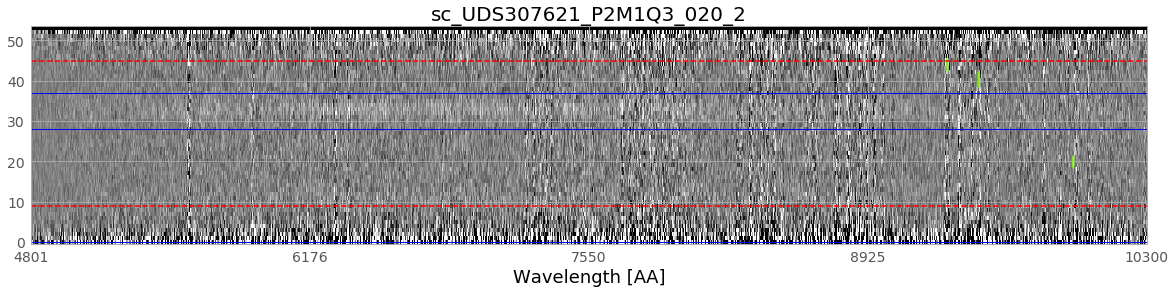

File:sc_UDS307693_P2M1Q3_P2M4Q3_003_1
Number of target galaxies:  1
Number of detections: 8


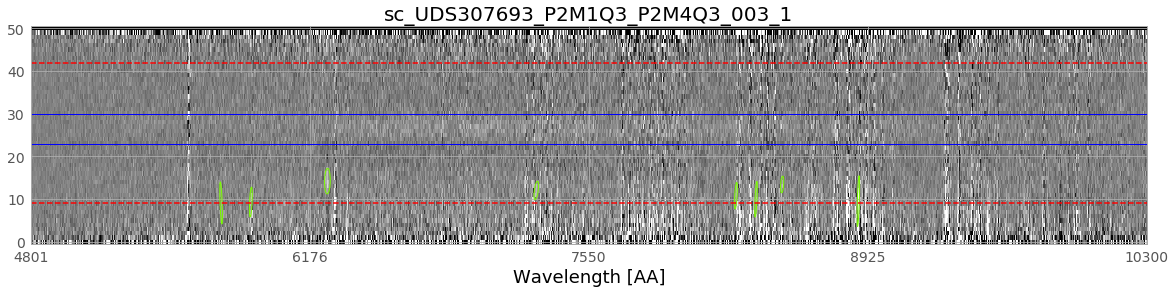

File:sc_UDS307726_P2M3Q3_P2M4Q3_022_1
Number of target galaxies:  1
Number of detections: 79


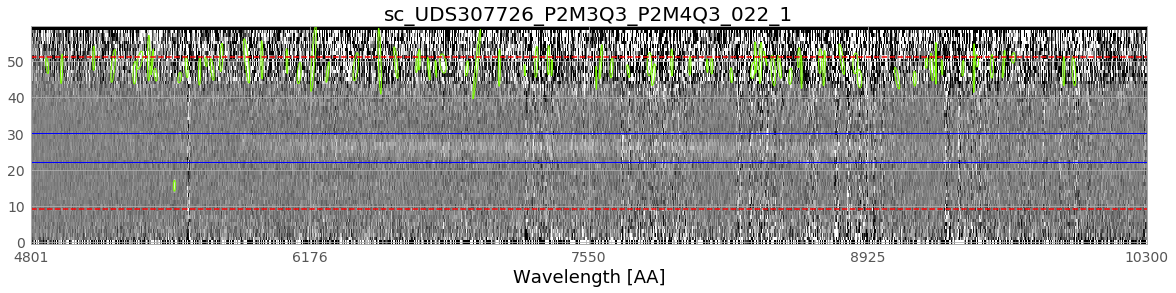

File:sc_UDS307828_P4M1Q3_P4M4Q3_P4M2Q3_P4M3Q3_009_1
Number of target galaxies:  1
Number of detections: 0


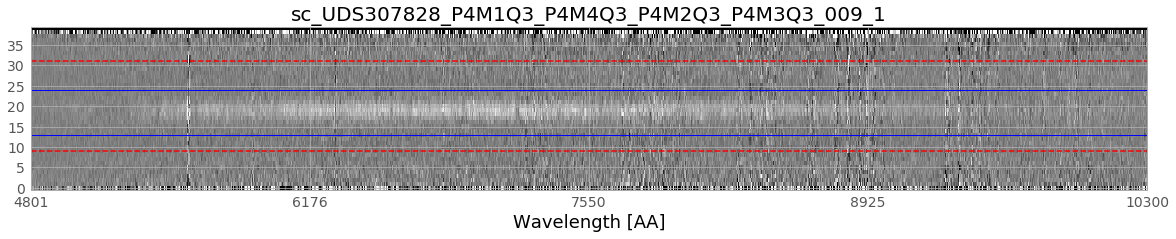

File:sc_UDS308333_P3M1Q3_003_2
Number of target galaxies:  2
Number of detections: 4


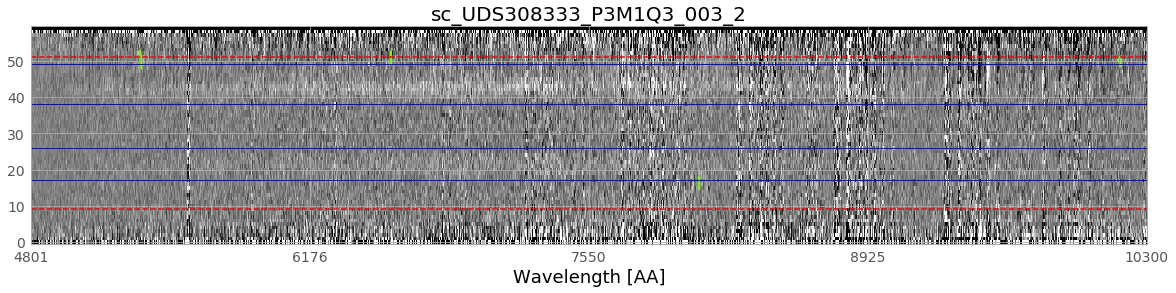

File:sc_UDS308474_P1M3Q4_P1M4Q4_027_2
Number of target galaxies:  2
Number of detections: 1


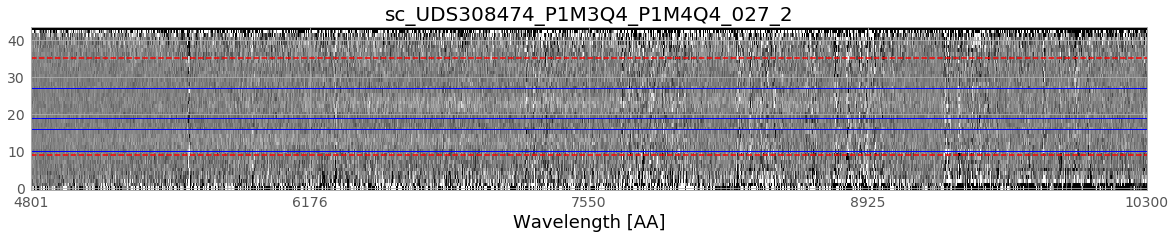

File:sc_UDS308872_P1M3Q3_P1M4Q3_009_1
Number of target galaxies:  1
Number of detections: 3


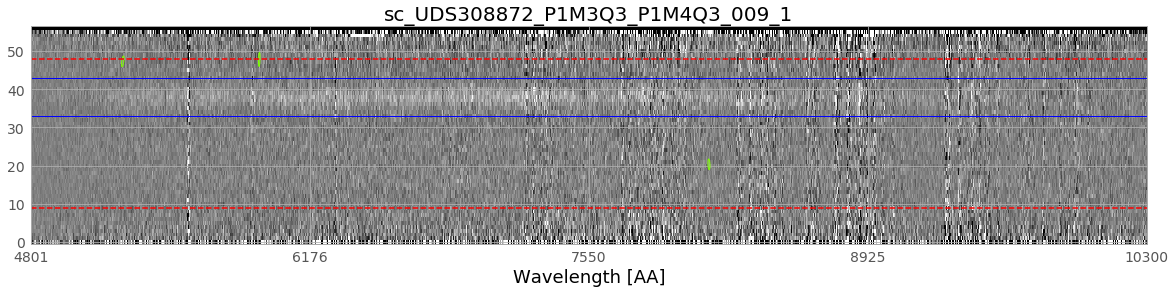

Missing keyword for file sc_UDS308933_P4M1Q3_P2M4Q3_003_5
Missing keyword for file sc_UDS308933_P4M1Q3_P2M4Q3_003_5
Missing keyword for file sc_UDS308933_P4M1Q3_P2M4Q3_003_5
File:sc_UDS308933_P4M1Q3_P2M4Q3_003_5
Number of target galaxies:  5
Number of detections: 18


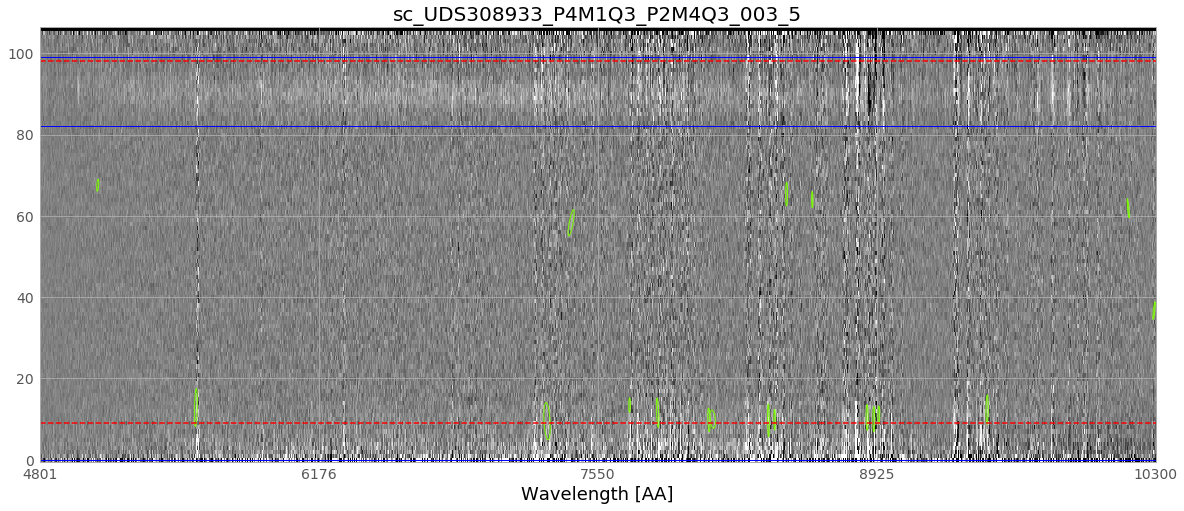

File:sc_UDS309060_P4M1Q3_P4M2Q3_006_1
Number of target galaxies:  1
Number of detections: 1


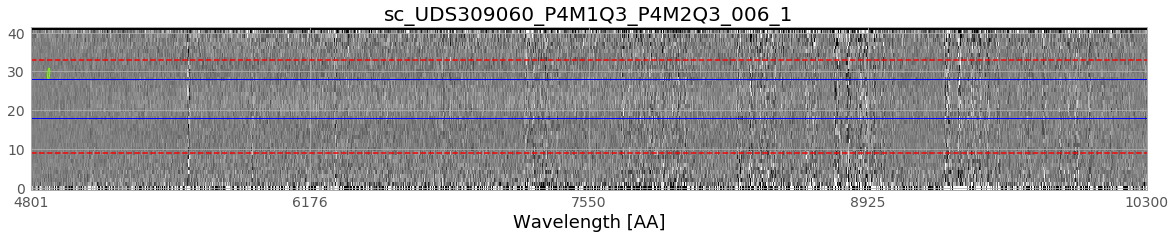

File:sc_UDS309407_P1M3Q4_P1M4Q4_028_1
Number of target galaxies:  1
Number of detections: 1


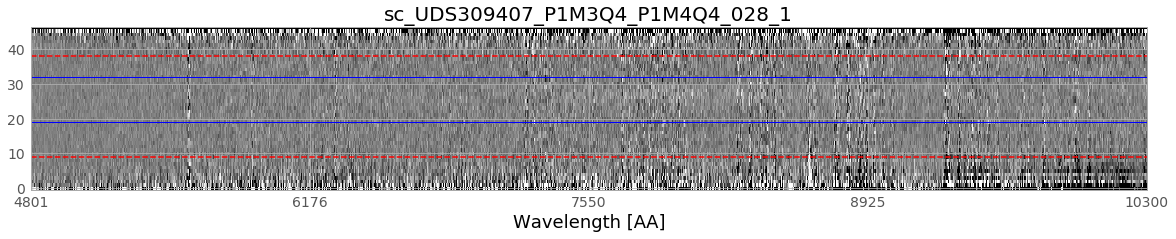

File:sc_UDS309597_P3M2Q3_008_1
Number of target galaxies:  1
Number of detections: 163


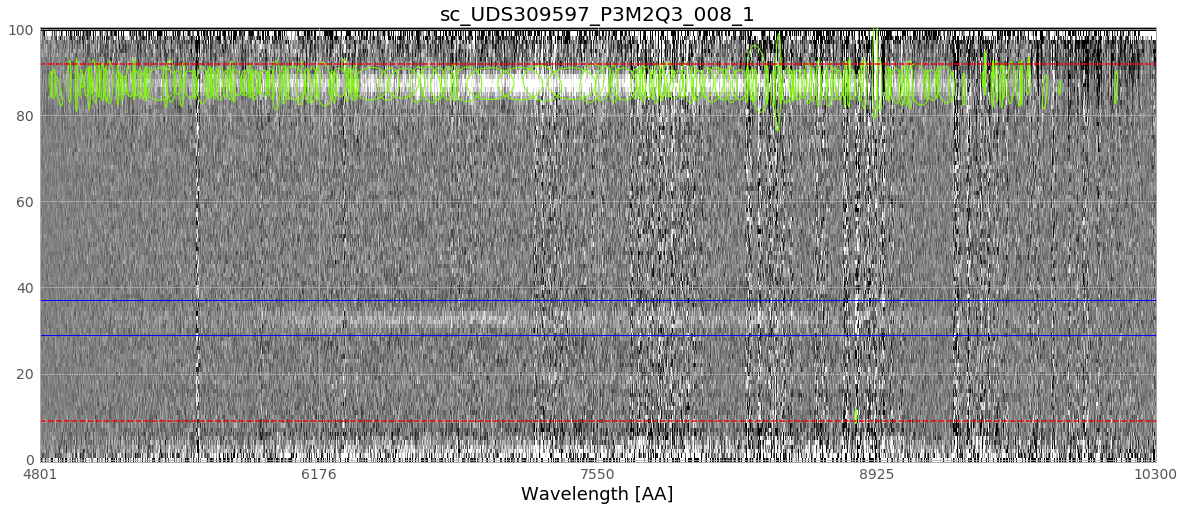

In [2]:
sample = 59

#namefile = open('/Users/sophiawilson/PUK/Split_Files_CDFS/CDFS_sample_'+str(sample)+'.txt')
namefile = open('/Users/sophiawilson/PUK/Split_Files_UDS/UDS_sample_'+str(sample)+'.txt')
edgecut = 9
plt.close('all')


for i in range(15):
    name = namefile.readline()
    name = name.strip("\n")
    name = name[:-5] #removes .fits 
    
#1D spectrum  
    #datafile = fits.open('/Users/sophiawilson/Documents/KU/PUK/PUKdata/MT_to_JF/CDFS_TARGETS_SPECTRA/'+name+'.fits')
    datafile = fits.open('/Users/sophiawilson/Documents/KU/PUK/PUKdata/MT_to_JF/UDS_TARGETS_SPECTRA/'+name+'.fits')
    hdr = datafile[0].header
    hdr2 = datafile[1].header
    flux = datafile[0].data
    err_flux = datafile[3].data #not used 
    wave = np.arange(len(flux))*hdr['CDELT1']+hdr['CRVAL1']

    image_data = datafile[1].data   #2D file
    
    ncol = hdr2['NAXIS1']   #Number of columns
    nrow = hdr2['NAXIS2']   #Number of rows
    nobj = hdr['PND OBJ']   #Number of sources in the 2dframe. We need to be able to handle 0, 1, 2, 3
    
#Wave used for xticks  
    xi = hdr2['CRVAL1']     #Wavelength start
    x0 = hdr2['CDELT1']     #wavelength per. pixel (column)
    xf = xi + x0*ncol       #Wavelength end

#Get position of target-galaxies in 2D spectrum. Can handle up to four target galaxies. 
    y11 = y12 = y21 = y22 = y31 = y32 = y41 = y42 = 0

    if nobj > 0:
        y11 = hdr2['PND WIN_OBJ_START']-2
        y12 = hdr2['PND WIN_OBJ_END']+2
        
    if nobj > 1:
        try:
            y21 = hdr2['PND WIN_OBJ1_START']-2
            y22 = hdr2['PND WIN_OBJ1_END']+2
        except KeyError: print('Missing keyword for file '+name)
            
    if nobj > 2:
        try:
            y31 = hdr2['PND WIN_OBJ2_START']-2
            y32 = hdr2['PND WIN_OBJ2_END']+2
        except KeyError: print('Missing keyword for file '+name)
            
    if nobj > 3:
        try:
            y41 = hdr2['PND WIN_OBJ3_START']-2
            y42 = hdr2['PND WIN_OBJ3_END']+2
        except KeyError: print('Missing keyword for file '+name)

#SExtractor
    image_data = image_data.byteswap().newbyteorder()

    
#2D array with bagground   
    data_sub = image_data 
    data_bg = data_sub.copy()
   
    c_all = [] 
    
    for j in range(ncol): 
        c = data_bg[:,j]                       #single colunm
        c[0:edgecut] = c[-edgecut:] = np.nan   #edges = NaN
        
        if nobj > 0: c[y11:y12] = np.nan       #targets = NaN
        if nobj > 1: c[y21:y22] = np.nan 
        if nobj > 3: c[y31:y32] = np.nan
        if nobj > 4: c[y41:y42] = np.nan
    
        s = np.nanstd(c)                       #standard deviation
        c_new = np.ones(nrow)*s                #column with std.
        c_all.append(c_new)

    c_all_arr = np.asarray(c_all, dtype=np.float32).transpose()     #This is used for plotting 2D image of background
    bg_err = np.ascontiguousarray(c_all_arr)                        #This is used in sep.extract

#Plot 2D image of bagground    
    #fig, ax = plt.subplots(figsize=(20,int(4*nrow/50.)))
    #im = ax.imshow(c_all_arr, interpolation='nearest', cmap='gray', aspect = 'auto',
    #           vmin=-0.01, vmax=0.01, origin='lower')
    #plt.title(name)
    #plt.colorbar(im)
    #plt.xlabel('Wavelength [AA]',size=18)
    #plt.xticks([3000],[1])
    #plt.yticks(size=14)
    #plt.show()
     
        
#Extracting objects         
    data_sub_bg = data_sub - bg_err
    objects = sep.extract(data_sub_bg, 0.5, err = bg_err)

    
#Plot       
    fig, ax = plt.subplots(figsize=(20,int(4*nrow/50.)))
    m, s = np.mean(data_sub), np.std(data_sub)
    im = ax.imshow(data_sub, interpolation='nearest', cmap='gray', aspect = 'auto',
               vmin=-0.01, vmax=0.01, origin='lower')
    plt.title(name,size=20)
    plt.axhline(edgecut, color='r', lw=1.5, linestyle='dashed')
    plt.axhline(nrow-edgecut, color='r', lw=1.5, linestyle='dashed')
    plt.xticks([0,2154/4,2154/2,3*2154/4,2154],[int(xi),int(((xf+xi)/2+xi)/2),int((xf+xi)/2),int(((xf+xi)/2+xf)/2),int(xf)],size=14)
    plt.xlabel('Wavelength [AA]',size=18)
    plt.yticks(size=14)
    
    if nobj > 0: plt.axhline(y11, color='b', lw=1.0) and plt.axhline(y12, color='b', lw=1.0)  
    if nobj > 1: plt.axhline(y21, color='b', lw=1.0) and plt.axhline(y22, color='b', lw=1.0)   
    if nobj > 2: plt.axhline(y31, color='b', lw=1.0) and plt.axhline(y32, color='b', lw=1.0)  
    if nobj > 3: plt.axhline(y41, color='b', lw=1.0) and plt.axhline(y42, color='b', lw=1.0)

    ndec = 0

    for i in range(len(objects)):
        e = Ellipse(xy=(objects['x'][i], objects['y'][i]),
               width=6*objects['a'][i],
               height=6*objects['b'][i],
               angle=objects['theta'][i] * 180. / np.pi)
        e.set_facecolor('none')
        e.set_edgecolor('lawngreen')
        
        if (objects['y'][i] > edgecut) & (objects['y'][i] < nrow-edgecut) & (int(objects['y'][i]) not in range(y11, y12)) & (int(objects['y'][i]) not in range(y21, y22)) & (int(objects['y'][i]) not in range(y31, y32)) & (int(objects['y'][i]) not in range(y41, y42)): 
            ax.add_artist(e)  
            ndec+=1
                
       
    print('File:'+name)     
    print('Number of target galaxies: ',hdr['PND OBJ'])           
    print('Number of detections:',ndec)
    plt.show()